# TD détection de communautés
Concepts :
- community detection
- node embedding
- clustering
- réduction de dimensions

In [1]:
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
from sklearn.cluster import KMeans, DBSCAN, OPTICS
import collections
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from node2vec import Node2Vec
from openTSNE import TSNE
import pandas as pd
import plotly.express as px

In [2]:
def format_comp(comp):
    partition = {}
    for id_cluster, community in enumerate(comp):
        for user in community:
            partition[user] = id_cluster + 1
    return partition

def plot_graph_with_communities(G, partition):
    pos = nx.spring_layout(G)
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                           cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

# I/ Avec du clustering de graphe

### 1) Appliquer l'algorithme de clustering Girvan-Newman sur le graphe des misérables et afficher les différentes étapes de construction
L'algorithme Girvan-Newman détecte les communautés en supprimant progressivement les arêtes du graphe original.
À chaque étape, l'algorithme supprime l'arête "la plus importante", traditionnellement celle dont la centralité d'intermédiaire est la plus élevée. Lorsque le graphe se décompose en morceaux, la structure de la communauté, très serrée, est exposée et le résultat peut être représenté sous forme de dendrogramme.

In [3]:
G2 = nx.read_gml("lesmiserables.gml")
comp = list(nx.algorithms.community.centrality.girvan_newman(G2))
print(len(comp))

76


/tmp/ipykernel_1585/3402000555.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


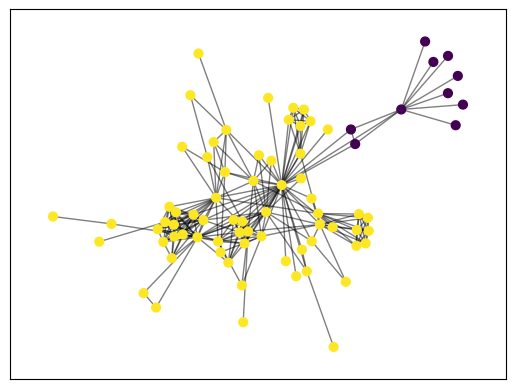

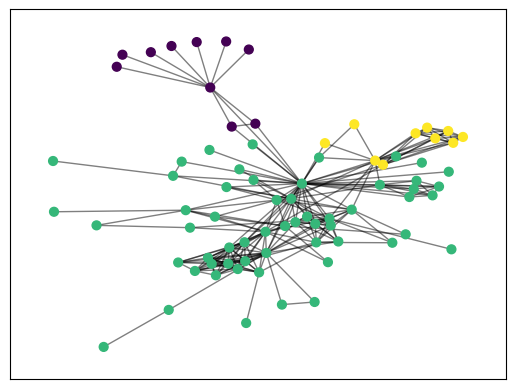

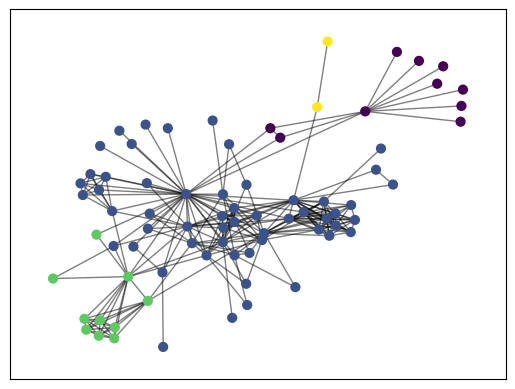

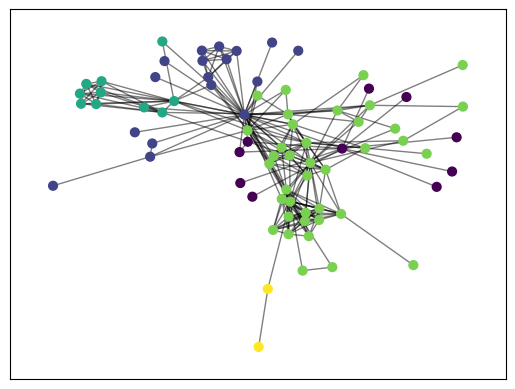

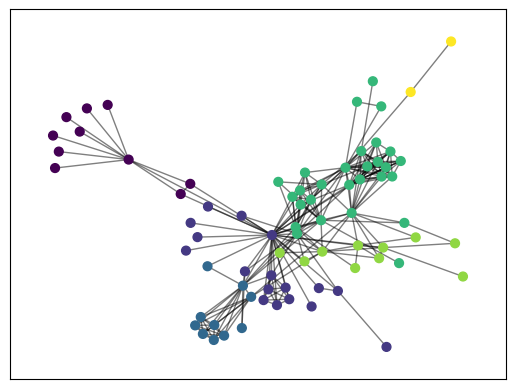

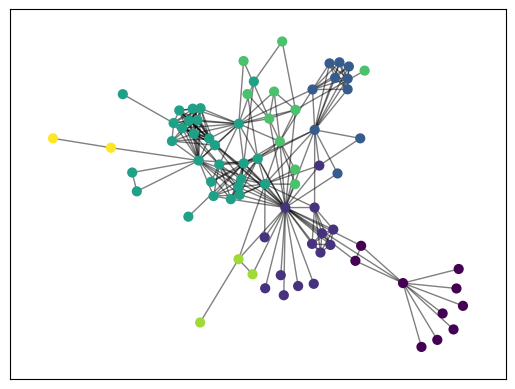

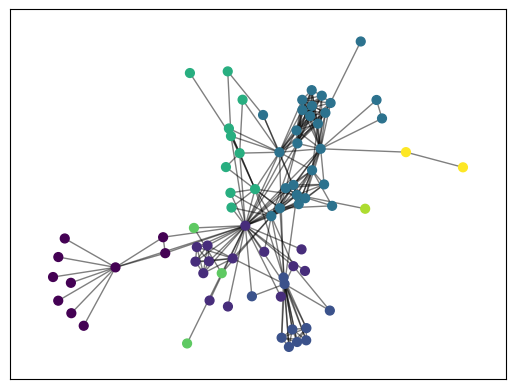

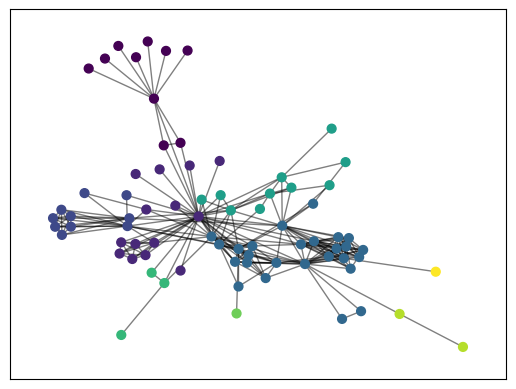

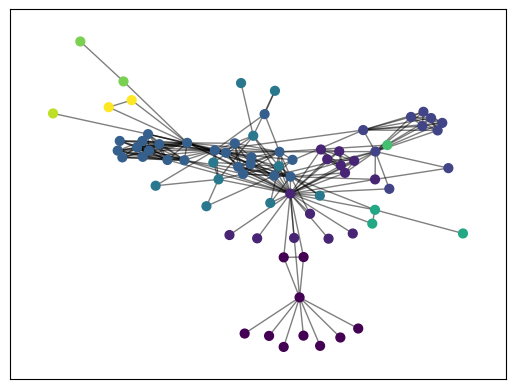

In [4]:
max_cluster = 10
for level_dendrogramme, clusters in enumerate(comp):
    if level_dendrogramme + 1 >= max_cluster:
        break
    comp = tuple(sorted(c) for c in clusters)
    partition = format_comp(comp)
    plot_graph_with_communities(G2, partition)

### 2) Appliquer l'algorithme de clustering Louvain sur le graphe de Game of Thrones

Voir: https://python-louvain.readthedocs.io/en/latest/api.html

In [5]:
df = pd.read_csv('got-s1-8-edges.csv')
G = nx.from_pandas_edgelist(df,
                            source='Source',
                            target='Target',
                            edge_attr=['Weight', 'Season'])
print(G)

Graph with 403 nodes and 2634 edges


In [ ]:
partition = # À compléter

In [ ]:
len(set(partition.values()))

**Afficher le graph avec les communautées**

In [ ]:
plot_graph_with_communities(G, partition)

# II/ Avec de l'embedding de noeuds

### 1) Appliquer un embedding sur les noeuds (Node2Vec)

Indice : utiliser `Node2Vec` en spécifiant `G` et `dimensions=64`. Puis entrainé (`fit()`) le modèle.

Voir: https://github.com/eliorc/node2vec

In [ ]:
%%time

# Precompute probabilities and generate walks
model = # À compléter

### 2) Regarder qui est le plus proche de DROGO grace à cet embedding

Indice : utiliser `model.wv.most_similar`

In [ ]:
# À compléter

### 3) Réduiser la dimension de l'embedding node2vec en 64d en 2d avec un T-SNE

Indice : utiliser `TSNE` et spécifier `n_components=2`. Puis entrainer le model (`fit`) en spécifiant les vecteurs d'embeddings de Node2Vec (`model.wv.vectors`), vous sauvegarderez le résultat dans la variable `X_embedded`.

Voir : https://github.com/pavlin-policar/openTSNE

In [ ]:
tsne = # À compléter
X_embedded = # À compléter
"On passe de " + str(model.wv.vectors.shape) + " à " + str(X_embedded.shape)

### 4) Afficher les noeuds embedded en 2d (utiliser Plotly)

Indice : réutiliser les communautés précédemment calculées (`id_community`) pour les afficher de différentes couleurs.

Voir: https://plotly.com/python/line-and-scatter/

In [ ]:
df_emb = pd.DataFrame(X_embedded, columns=['x', 'y'])
df_emb['name'] = model.wv.index_to_key
df_emb['id_community'] = df_emb['name'].apply(lambda name: partition[name])
df_emb.head()

In [ ]:
fig = px.scatter(df_emb, # À compléter)
fig.show()

### 5) Appliquer chacun son tour un de ces algorithmes de clustering (KMeans, DBSCAN, OPTICS) sur les noeuds embedded en 64d, puis afficher les noeuds en 2d en utilisant l'id du cluster comme couleur

In [ ]:
#X = model.wv.vectors # sur les 64d de l'embedding, plus précis mais collera moins bien à la viz en 2d
X = df_emb[['x', 'y']] # sur 2d, mois précis mais collera mieux à la viz en 2d

clusterings = [
    KMeans(n_clusters=7),
    DBSCAN(min_samples=3, eps=0.5),
    OPTICS(min_samples=3)
]

for clustering in clusterings:
    print(clustering)
    clustering = clustering.fit(X)
    print('%d clusters' % len(list(set(clustering.labels_))))

    df_emb['id_cluster'] = clustering.labels_
    fig = px.scatter(df_emb, x='x', y='y', hover_name='name', color='id_cluster', height=800)
    fig.show()

    # Pour afficher le nombre de noeuds par cluster:
    # pd.DataFrame(clustering.labels_).hist(bins=len(clustering.labels_))

### 6) Comparer une méthode de détection de communauté comme Louvain VS embedding + clustering

Constat : à compléter